#### Benchmark Analysis: The Q70 Free Shuttle Service 

Let the "system" be defined as a passenger journey from any point in Manhattan south of 60th st to LGA Airport. Assumptions are as follows:
* Subway from Manhattan to Jackson Heights/Woodside is somewhere between 20-40 min. on average (source: Google Maps)
* We can approximate the wait-time distribution at Jackson Heights/Woodside via GTFS feeds
* The time on the q70 service is measured without congestion effects, though this can be looked at via the GTFS feed for analysis sake. The modelling data however is obtained from osmnx, which calculates network flow costs based on speed limits. 

In [3]:
import sqlite3
import pandas as pd 
import numpy as np 

db_path = 'bus_locations_benchmark2.db'
con = sqlite3.connect(db_path)

pd.read_sql('''select distinct StopPointName from q70;''', con = con)


,StopPointName
0,ROOSEVELT AV/75 ST
1,LAGUARDIA RD/94 ST
2,WOODSIDE AV/61 ST
3,LGA INTERNAL RDWY/TERMINAL C
4,LGA/TERMINAL B
5,74 ST/ROOSEVELT AV STATION


In [5]:
wait_times = pd.read_sql('''
select 
    VehicleID,
    strftime('%H' , RecordTime, 'localtime') as hour, 
    strftime('%d', RecordTime, 'localtime') as day,
    avg(ArrivalDelta) as arrival_delta
from q70
where StopPointName = '74 ST/ROOSEVELT AV STATION'
    and ArrivalDelta is not null 
group by 1,2,3
order by 2,3
;
''', 
con = con
)

wait_times.head(10)

,VehicleID,hour,day,arrival_delta
0,MTABC_6278,00,26,-5.313850
1,MTABC_6275,00,27,-4.889263
2,MTABC_6277,00,27,-2.830072
3,MTABC_6285,00,27,-36.236817
4,MTABC_6286,00,27,-0.036807
5,MTABC_6280,01,26,-0.670433
6,MTABC_6281,01,26,-4.276872
7,MTABC_6286,01,27,1.300500
8,MTABC_6278,02,26,-0.976900
9,MTABC_6280,02,26,3.208833


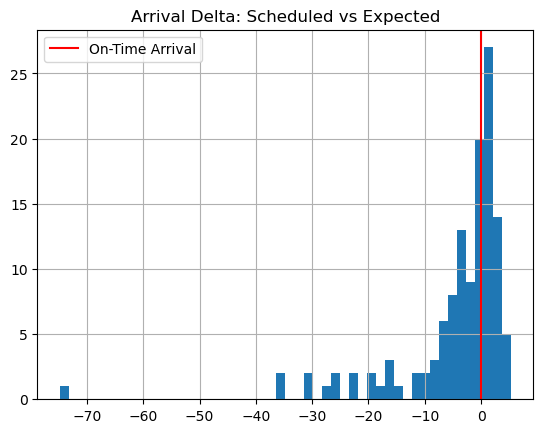

In [7]:
import matplotlib.pyplot as plt
wait_times['arrival_delta'].hist(bins=50)
plt.title('Arrival Delta: Scheduled vs Expected')
plt.axvline(0,color='red',label='On-Time Arrival')
plt.legend()
plt.show()

In [8]:
on_schedule = np.count_nonzero(wait_times['arrival_delta'] >= 0) / len(wait_times)
late = 1 - on_schedule
print(f'Late Proportion: {late}')
print(f'Scheduled Proportion: {on_schedule}')

Late Proportion: 0.5952380952380952
Scheduled Proportion: 0.40476190476190477


In [11]:
wait_times['arrival_delta'].mean()

-4.537137518065177

In [13]:
wait_times.loc[wait_times['arrival_delta'] < 0]['arrival_delta'].mean()

-8.957032911308662

In [15]:
wait_times

,VehicleID,hour,day,arrival_delta
0,MTABC_6278,00,26,-5.313850
1,MTABC_6275,00,27,-4.889263
2,MTABC_6277,00,27,-2.830072
3,MTABC_6285,00,27,-36.236817
4,MTABC_6286,00,27,-0.036807
...,...,...,...,...
121,MTABC_6285,22,26,1.702825
122,MTABC_6276,23,26,1.191043
123,MTABC_6278,23,26,2.573480
124,MTABC_6281,23,26,-2.289452


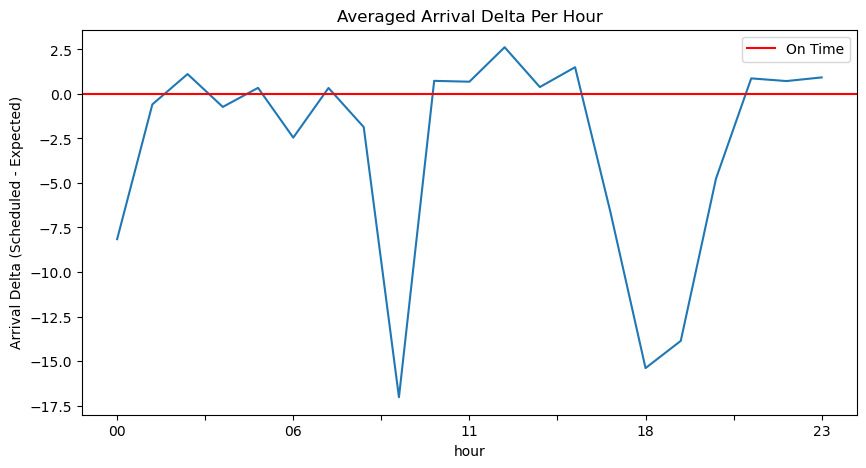

In [17]:
wait_times\
    .loc[wait_times['day'].isin(['26','27'])]\
    .groupby(['hour','day'])[['arrival_delta']]\
    .mean()\
    .reset_index()\
    .pivot(
        index='hour',
        columns='day',
        values='arrival_delta'
    )\
    .mean(axis=1)\
    .plot(
        title='Averaged Arrival Delta Per Hour', 
        figsize=(10,5),
        ylabel='Arrival Delta (Scheduled - Expected)'
    )
plt.axhline(0,color='red',label='On Time')
plt.legend()
plt.show()

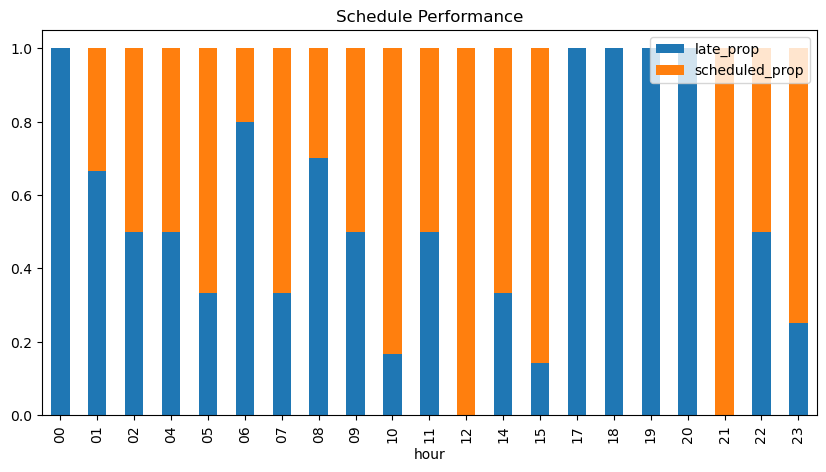

In [19]:
hourly_perf = \
wait_times\
    .loc[wait_times['day'].isin(['26','27'])]\
    .groupby(['hour'])\
    .agg(late_prop=\
            pd.NamedAgg(\
                column='arrival_delta',
                aggfunc=lambda x: np.count_nonzero(x < 0)/len(x)
            )
        )
hourly_perf['scheduled_prop']= 1 - hourly_perf['late_prop']
hourly_perf.plot(
    kind='bar',
    stacked=True,
    title='Schedule Performance', 
    figsize=(10,5),
) 
plt.show()

#### Approximate passenger wait-times

Analyze service rates

In [22]:
#(weekday) headways are around 8 min...https://new.mta.info/document/6621
derive_wait_approximations = \
pd.read_sql('''
    select *, max(-ArrivalDelta+headway_gap, headway_gap) as max_wait_approximation
    from (
    select 
        *, 
         case
            when hour between 0 and 5 then 20
            when hour between 5 and 12 then 10 
            else 8
        end as headway_gap
    from (
    select  
        VehicleID,
        RecordTime,
        ArrivalDelta,
        cast(strftime('%H' , RecordTime, 'localtime') as int) as hour, 
        cast(strftime('%d', RecordTime, 'localtime') as int) as day 
    from q70 
    where StopPointName = '74 ST/ROOSEVELT AV STATION'
    ));''', 
    con = con
)

derive_wait_approximations.head()

,VehicleID,RecordTime,ArrivalDelta,hour,day,headway_gap,max_wait_approximation
0,MTABC_6278,2024-11-26 00:46:13-05:00,-5.489050,0,26,20,25.489050
1,MTABC_6278,2024-11-26 00:47:15-05:00,-5.407767,0,26,20,25.407767
2,MTABC_6278,2024-11-26 00:48:17-05:00,-4.912083,0,26,20,24.912083
3,MTABC_6278,2024-11-26 00:49:18-05:00,-5.446500,0,26,20,25.446500
4,MTABC_6280,2024-11-26 01:01:09-05:00,-0.583517,1,26,20,20.583517


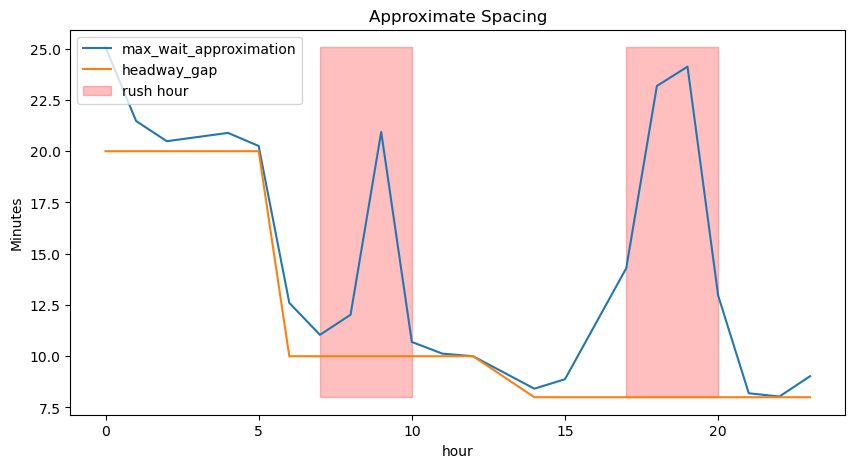

In [24]:
#headway_blocks = \
#dict(zip(['AM1', 'AM2', 'PM'], derive_wait_approximations['headway_gap'].unique()))

#for name, headway_gap in headway_blocks.items():
 #   t = derive_wait_approximations.loc[derive_wait_approximations['headway_gap'] == headway_gap]
  #  t = t.loc[t['max_wait_approximation'] < 60]
   # t['max_wait_approximation'].hist(bins=50)
   # plt.show()

#note, the max-waittime is eq to the approx spacing of each bus
derive_wait_approximations['rush_hour'] = \
derive_wait_approximations['hour'].isin(np.append(np.arange(7,11),np.arange(16,21)))
rush_hour_blocks = derive_wait_approximations[['hour','rush_hour']].sort_values(['hour']).drop_duplicates()
fig,ax=plt.subplots()
grp = derive_wait_approximations\
   .groupby(['hour'])[['max_wait_approximation','headway_gap']]\
   .mean()
grp.plot(
   title='Approximate Spacing', 
   figsize=(10,5), 
   ylabel='Minutes',
   ax=ax
)
min_y = grp['max_wait_approximation'].min()
max_y = grp['max_wait_approximation'].max()

ax.fill_between(
    rush_hour_blocks['hour'], 
    min_y, 
    max_y, 
    where=rush_hour_blocks['rush_hour'], 
    alpha=0.25, 
    color='red', 
    label='rush hour'
)
plt.legend()
plt.show()

In [26]:
grp['expected_bus_arrivals (mu_exp)'] = 60 / grp['headway_gap'] 
grp['actual_bus_arrivals (mu)'] = 60 / grp['max_wait_approximation'] 

grp

,max_wait_approximation,headway_gap,expected_bus_arrivals (mu_exp),actual_bus_arrivals (mu)
hour,,,,
0,25.072357,20.0,3.0,2.393074
1,21.471162,20.0,3.0,2.794446
2,20.488450,20.0,3.0,2.928479
4,20.893600,20.0,3.0,2.871693
5,20.254562,20.0,3.0,2.962296
6,12.602926,10.0,6.0,4.760799
7,11.043188,10.0,6.0,5.433214
8,12.022996,10.0,6.0,4.990437
9,20.938081,10.0,6.0,2.865592


#### Model Demand wrto Service 

Arrival Rates

In [29]:
import requests
import pandas as pd 
bus_ridership_endpoint = 'https://data.ny.gov/resource/kv7t-n8in.json'
r=requests.get(
        url = bus_ridership_endpoint, 
        params={
            '$select':'transit_timestamp,SUM(ridership) as ridership',
            '$where':"bus_route='Q70+' AND (transit_timestamp between '2022-01-01' AND '2022-04-22') ",
            '$group':'transit_timestamp',
            '$limit':50000
        }
    )
ridership = pd.DataFrame(r.json())
ridership['hour'] = pd.to_datetime(ridership['transit_timestamp']).dt.hour
ridership['day'] = pd.to_datetime(ridership['transit_timestamp']).dt.day
ridership['dow'] = pd.to_datetime(ridership['transit_timestamp']).dt.day_of_week
ridership['month'] = pd.to_datetime(ridership['transit_timestamp']).dt.month 
ridership['year'] = pd.to_datetime(ridership['transit_timestamp']).dt.year 

ridership = ridership.drop(
    columns=['transit_timestamp']
)
ridership['ridership'] = ridership['ridership'].astype(np.float64)
#ridership['transfers'] = ridership['transfers'].astype(np.float64)
grp_ridership = ridership.groupby(['day','month','year','dow']).sum().reset_index()
grp_ridership.head()
#only2022 = grp_ridership.loc[(grp_ridership['year']==2022)&(grp_ridership['month'] < 4)&(grp_ridership['dow'] < 5)] #get most recent ridership stats
#only2022 = only2022.loc[only2022['ridership'] > 1500]['ridership'].mean()

#only2022.groupby(['hour'])['ridership'].mean() 


,day,month,year,dow,ridership,hour
0,1,1,2022,5,692.118999,276
1,1,2,2022,1,3494.312004,276
2,1,3,2022,1,3115.599002,276
3,1,4,2022,4,2493.095998,276
4,2,1,2022,6,573.776999,276


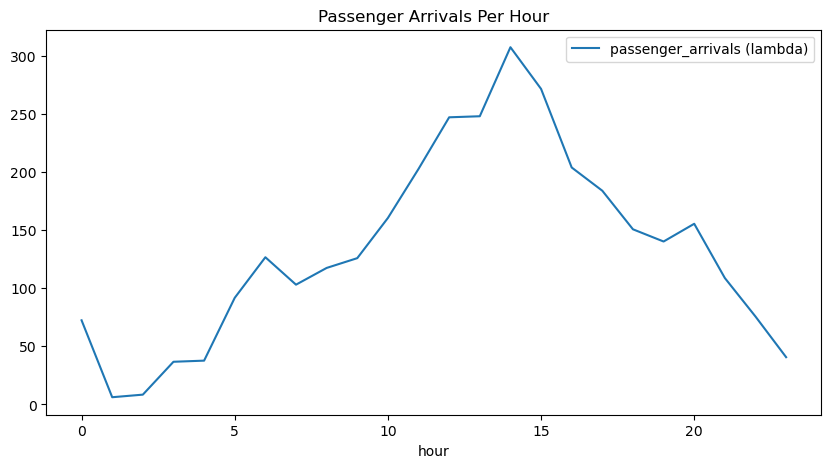

In [32]:
ridership = ridership.loc[(ridership['year']==2022)&(ridership['month'] < 4)&(ridership['dow'] < 5)] 
demand_arr_rates = ridership.groupby(['hour'])[['ridership']].median()
demand_arr_rates = demand_arr_rates.rename(columns={'ridership': 'passenger_arrivals (lambda)'})
demand_arr_rates['passenger_interarrival_gaps'] = 60 / demand_arr_rates['passenger_arrivals (lambda)']
demand_arr_rates['passenger_arrivals (lambda)'] *= 1.5 #note this is possibly an underestimate since it is a free service, sample upwards 
demand_arr_rates[['passenger_arrivals (lambda)']].plot(figsize=(10,5))
plt.title('Passenger Arrivals Per Hour')
plt.show()

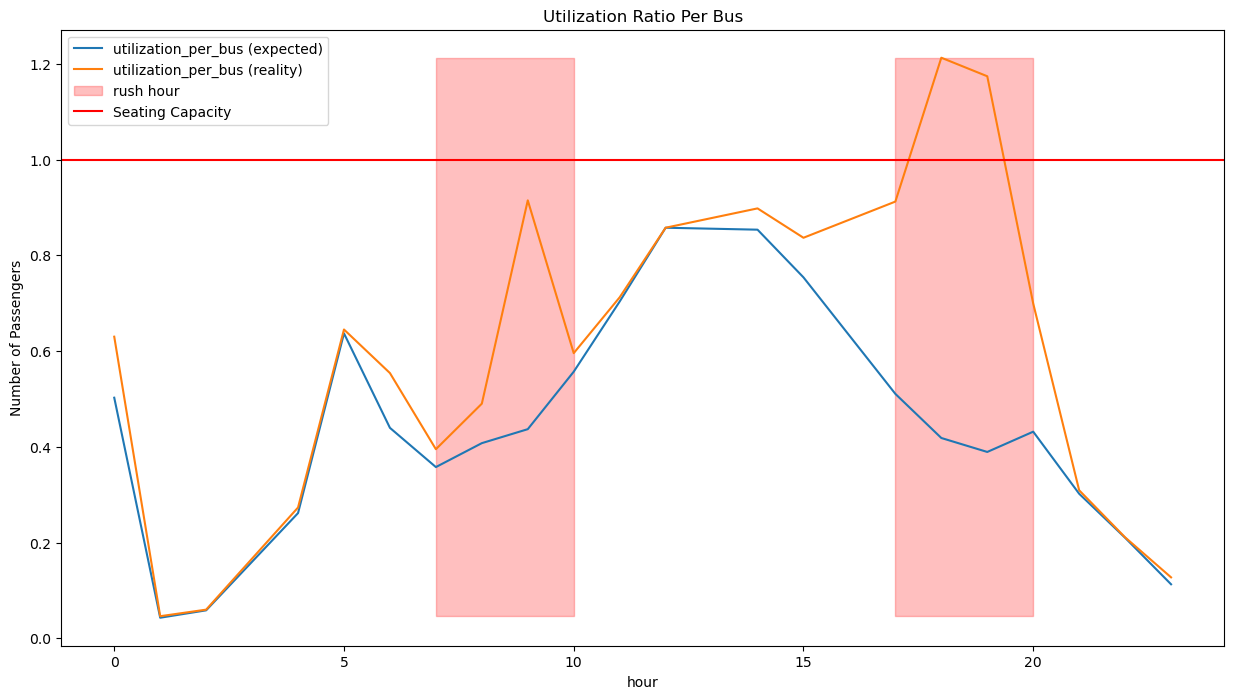

In [42]:
import warnings
warnings.filterwarnings('ignore')
combined = pd.concat((grp,demand_arr_rates),axis=1).dropna()
queue_features = \
combined[[
    'actual_bus_arrivals (mu)',
    'expected_bus_arrivals (mu_exp)', 
    'passenger_arrivals (lambda)'
]]

fig,ax=plt.subplots()
queue_features['utilization_per_bus (expected)'] = \
(queue_features['passenger_arrivals (lambda)'] / queue_features['expected_bus_arrivals (mu_exp)']) / 48
queue_features['utilization_per_bus (reality)'] = \
(queue_features['passenger_arrivals (lambda)'] / queue_features['actual_bus_arrivals (mu)']) / 48
queue_features[[
    'utilization_per_bus (expected)',
    'utilization_per_bus (reality)'
]].plot(
    title='Utilization Ratio Per Bus',
    figsize=(15,8), 
    ylabel='Number of Passengers',
    ax=ax
)

min_y=queue_features['utilization_per_bus (reality)'].min()
max_y=queue_features['utilization_per_bus (reality)'].max()

ax.fill_between(
    rush_hour_blocks['hour'], 
    min_y, 
    max_y, 
    where=rush_hour_blocks['rush_hour'], 
    alpha=0.25, 
    color='red', 
    label='rush hour'
)

#assume capacity is set at 48
plt.axhline(1.0, color='red', label='Seating Capacity')

plt.legend()
plt.show()

In [36]:
(pd.concat((queue_features,rush_hour_blocks.set_index('hour')),axis=1)\
   .groupby(['rush_hour'])[['passengers_per_bus (expected)','passengers_per_bus (reality)']].max()) / 48


,passengers_per_bus (expected),passengers_per_bus (reality)
rush_hour,,
False,0.857565,0.897945
True,0.556906,1.212616


In [214]:
queue_features

,actual_bus_arrivals (mu),expected_bus_arrivals (mu_exp),passenger_arrivals (lambda),passengers_per_bus (expected),passengers_per_bus (reality)
hour,,,,,
0,2.393074,3.0,72.368999,24.123000,30.241024
1,2.794446,3.0,6.202500,2.067500,2.219581
2,2.928479,3.0,8.424000,2.808000,2.876578
4,2.871693,3.0,37.668000,12.556000,13.117002
5,2.962296,3.0,91.713750,30.571250,30.960365
6,4.760799,6.0,126.606750,21.101125,26.593592
7,5.433214,6.0,103.017749,17.169625,18.960740
8,4.990437,6.0,117.406500,19.567750,23.526297
9,2.865592,6.0,125.818500,20.969750,43.906632


In [216]:
total_time_in_system_max = 40 + grp['max_wait_approximation'].max() + 15
total_time_in_system_max

80.07235740740741

In [218]:
total_time_in_system_min = 20 + 15
total_time_in_system_min

35